In [60]:
import os
import numpy as np
import rasterio as rio

from matplotlib import pylab
from sklearn.decomposition import PCA

# PCA on GeoTiff

The aim of this notebook is to read in a `GeoTiff` raster of information and decompose all the bands into a single image through [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).

### Import image and convert to numerical arrays

In [66]:
bands = {}

for filename in os.listdir(image_name):
    if filename.endswith("tif"):
        with rio.open(os.path.join(image_name, filename)) as tiff_file:
            band_name = filename.split(".")[1]
            bands[band_name] = tiff_file.read(1)

bands_matrix = np.array(
    list(bands.values())
)

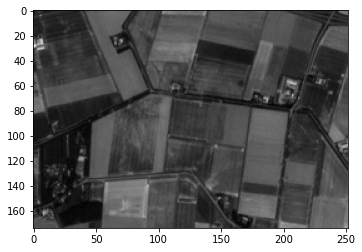

In [67]:
pylab.imshow(list(bands.values())[1], cmap="gray")

In [81]:
height, width = list(bands.values())[0].shape

### Apply PCA to all data

We need to flatten the matrix to 1D before passing through PCA

In [95]:
bands_matrix_flattened = []
for band in bands_matrix:
    bands_matrix_flattened.append(band.flatten())
    
bands_flattened = np.array(bands_matrix_flattened)
bands_flattened.shape

(4, 43848)

We need to invert the dimensions so we have the channels as features

In [96]:
channels_last_bands = np.swapaxes(bands_flattened, 0, 1)
channels_last_bands.shape

(43848, 4)

In [97]:
pca = PCA(n_components=3)
channels_last_pca = pca.fit_transform(channels_last_bands)

In [139]:
pca.explained_variance_ratio_

array([0.57311398, 0.40912534, 0.01615832])

We now need to go back to channels first, and try displaying the resulting image

In [98]:
pca_flattened = np.swapaxes(channels_last_pca, 0, 1)
pca_flattened.shape

(3, 43848)

And now we must transpose it back to matrix

In [117]:
pca_matrix = np.rollaxis(
    np.array([channel.reshape(height, width) for channel in pca_flattened]),
    0, 3
)

pca_matrix.shape

(174, 252, 3)

In [130]:
final_image = (pca_matrix - pca_matrix.min()) / (pca_matrix.max() - pca_matrix.min())

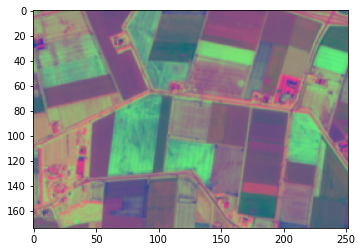

In [159]:
matplot_pca_image = final_image[:, :, [1, 0, 2]]
pylab.imshow(matplot_pca_image)

In [135]:
original_image = (bands_matrix - bands_matrix.min()) / (bands_matrix.max() - bands_matrix.min())

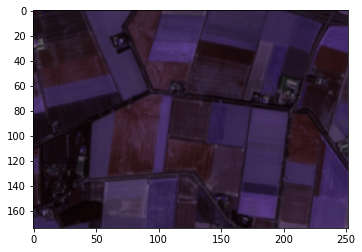

In [158]:
matplot_original_image = np.rollaxis(original_image[[0, 1, 2]], 0, 3)
pylab.imshow(matplot_original_image)

Apparently images look quite nice! Let's export them for better inspection

In [161]:
pylab.imsave("original.png", matplot_original_image)
pylab.imsave("pca_decomp.png", matplot_pca_image)